In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random
import struct
import subprocess
import sys
from matplotlib.patches import Rectangle

In [2]:
base_dir = os.getcwd()
exec_dir = '..'

---
# Print root rectangles

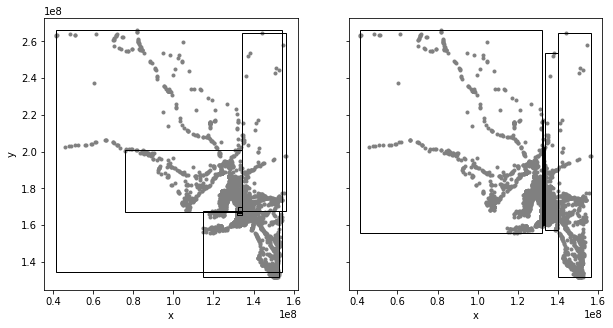

In [31]:
df = pd.read_csv(input_file)
rect1 = pd.read_csv('test_morton/zindex_rects.csv')
rect2 = pd.read_csv('test_morton/lexi_rects.csv')


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
#fig.suptitle('Bounding rectangles at the root with Z-index (left) and lexicographic sorting (right)')

ax1 = plt.subplot(1, 2, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df.x, df.y, marker=".", color='gray')
for index, row in rect1.iterrows():
    r = (row.lx, row.ly, row.ux, row.uy)
    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
    
ax2=plt.subplot(1, 2, 2)
plt.xlabel("x")
plt.scatter(df.x, df.y, marker=".", color='gray')
for index, row in rect2.iterrows():
    r = (row.lx, row.ly, row.ux, row.uy)
    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
    
plt.savefig("test_morton/tree-rectangles.png", format='png', bbox_inches='tight')

---
# Queries with Morton index

We select the data set with $m=30000$ records and transform it by mapping points into the rank space.

In [3]:
data_file = 'data/crash_data_30000.csv'
output_data = 'data/morton/morton_data_30000.csv'

In [4]:
data = pd.read_csv(data_file)
sx = data['x'].sort_values().reset_index(drop = True)
sy = data['y'].sort_values().reset_index(drop = True)
xmap = dict((v,k) for k,v in sx.iteritems())
ymap = dict((v,k) for k,v in sy.iteritems())
def xrank(v): return xmap[v]
def yrank(v): return ymap[v]
data['mx'] = data['x'].apply(xrank)
data['my'] = data['y'].apply(yrank)
data.head()

,ID,Year,Month,Day,Time,x,y,mx,my
0,2015-14247-27/05/2021,2015,December,Wednesday,01:45 pm,131947650,164099168,3076,1913
1,2017-7396-27/05/2021,2017,July,Sunday,06:40 pm,132482790,166008711,8815,5147
2,2020-9083-27/05/2021,2020,October,Sunday,08:10 pm,132032705,165391235,3596,3905
3,2018-11879-27/05/2021,2018,November,Wednesday,03:35 pm,132519602,166025289,9195,5221
4,2013-10620-27/05/2021,2013,August,Thursday,12:45 pm,133558545,169376927,23507,25890


Then we also map to the rank space all previously generated queries with fraction from 1% to 9%.

In [5]:
def map_lower_x(lx): 
    return np.min(data[data.x >= lx]['mx'])
def map_lower_y(ly): 
    return np.min(data[data.y >= ly]['my'])
def map_upper_x(ux): 
    return np.max(data[data.x <= ux]['mx'])
def map_upper_y(uy): 
    return np.max(data[data.y <= uy]['my'])

In [6]:
for f in range(1, 10):
    query_file = 'data/random_queries_{}.csv'.format(f)
    output_query = 'data/morton/morton_queries_{}.csv'.format(f)
    queries = pd.read_csv(query_file)
    queries['lx'] = queries['lx'].apply(map_lower_x)
    queries['ly'] = queries['ly'].apply(map_lower_y)
    queries['ux'] = queries['ux'].apply(map_upper_x)
    queries['uy'] = queries['uy'].apply(map_upper_y)
    queries.to_csv(output_query, index=False)
print('Done!')

Done!


In [7]:
data = data.drop(columns=['x', 'y'])
data = data.rename(columns={"mx": "x", "my": "y"})
data.to_csv(output_data, index=False)

This is the final result for the transformed data set with $m=30000$.

In [8]:
morton = pd.read_csv('data/morton/morton_data_30000.csv')
morton.head()

,ID,Year,Month,Day,Time,x,y
0,2015-14247-27/05/2021,2015,December,Wednesday,01:45 pm,3076,1913
1,2017-7396-27/05/2021,2017,July,Sunday,06:40 pm,8815,5147
2,2020-9083-27/05/2021,2020,October,Sunday,08:10 pm,3596,3905
3,2018-11879-27/05/2021,2018,November,Wednesday,03:35 pm,9195,5221
4,2013-10620-27/05/2021,2013,August,Thursday,12:45 pm,23507,25890


We test fractions from 1% to 9% with the rank space mapping + Z-index sorting approach.

We set $m=30000$ records and $c=16$ as we did with queries in the original space.

In [9]:
c=16
m=30000
input_file = '{}/data/morton/morton_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_morton/morton_fraction.csv'.format(base_dir)
f = open(output_file, 'w')
f.write('fraction,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for i in range(1, 10):
    print('Testing fraction = {}%...'.format(i))
    query_file = '{}/data/morton/morton_queries_{}.csv'.format(base_dir, i)
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{},{},{},{},{}\n'.format(i,avg_retur,avg_match,avg_query,avg_verif))
    
f.close()

os.chdir(base_dir)
print('Done!')

Testing fraction = 1%...
Testing fraction = 2%...
Testing fraction = 3%...
Testing fraction = 4%...
Testing fraction = 5%...
Testing fraction = 6%...
Testing fraction = 7%...
Testing fraction = 8%...
Testing fraction = 9%...
Done!


In [10]:
df=pd.read_csv('test_morton/morton_fraction.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'fraction':str, 'avg_returned': int, 'avg_matching': int})
# Add % to fraction column.
df['fraction'] = df['fraction'] + '%'
# Compute the noise
df['noise'] = 1-(df['avg_matching']/df['avg_returned'])
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'noise':3, 'avg_query': 3, 'avg_verif': 3})
# Reorder columns.
df = df[['fraction','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
fraction &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
      1\% &          1922 &           300 &  0.844 &      0.173 &      1.105 \\
      2\% &          2406 &           601 &  0.750 &      0.220 &      1.416 \\
      3\% &          3016 &           897 &  0.703 &      0.291 &      1.886 \\
      4\% &          3617 &          1198 &  0.669 &      0.359 &      2.403 \\
      5\% &          4048 &          1499 &  0.630 &      0.388 &      2.523 \\
      6\% &          4283 &          1798 &  0.580 &      0.423 &      2.890 \\
      7\% &          4584 &          2099 &  0.542 &      0.470 &      3.179 \\
      8\% &          4806 &          2399 &  0.501 &      0.474 &      3.298 \\
      9\% &          5105 &          2701 &  0.471 &      0.506 &      3.525 \\
\bottomrule
\end{tabular}



---
# Queries with lexicographical sorting

We repeat the same experiment as before (for fractions between 1% and 9%) but we avoid sorting using the Z-index.

This time we sort points according to the lexicographical order on the **original data**.

We use $m=30000$ and $c=16$ as usual.

In [11]:
m=30000
c=16
input_file = '{}/data/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_morton/lexi_fraction.csv'.format(base_dir)

In [12]:
f = open(output_file, 'w')
f.write('fraction,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for i in range(1, 10):
    print('Testing fraction = {}%...'.format(i))
    query_file = '{}/data/random_queries_{}.csv'.format(base_dir, i)
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{},{},{},{},{}\n'.format(i,avg_retur,avg_match,avg_query,avg_verif))
    
f.close()

os.chdir(base_dir)
print('Done!')

Testing fraction = 1%...
Testing fraction = 2%...
Testing fraction = 3%...
Testing fraction = 4%...
Testing fraction = 5%...
Testing fraction = 6%...
Testing fraction = 7%...
Testing fraction = 8%...
Testing fraction = 9%...
Done!


In [13]:
df=pd.read_csv('test_morton/lexi_fraction.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'fraction':str, 'avg_returned': int, 'avg_matching': int})
# Add % to fraction column.
df['fraction'] = df['fraction'] + '%'
# Compute the noise
df['noise'] = 1-(df['avg_matching']/df['avg_returned'])
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'noise':3, 'avg_query': 3, 'avg_verif': 3})
# Reorder columns.
df = df[['fraction','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
fraction &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
      1\% &          3239 &           300 &  0.907 &      0.296 &      1.711 \\
      2\% &          6582 &           601 &  0.909 &      0.640 &      3.341 \\
      3\% &          7491 &           897 &  0.880 &      0.718 &      3.896 \\
      4\% &          9709 &          1198 &  0.877 &      0.928 &      5.040 \\
      5\% &         10596 &          1499 &  0.859 &      1.012 &      5.576 \\
      6\% &         14833 &          1798 &  0.879 &      1.472 &      7.688 \\
      7\% &         14729 &          2099 &  0.857 &      1.424 &      7.765 \\
      8\% &         15941 &          2399 &  0.850 &      1.530 &      8.444 \\
      9\% &         16214 &          2701 &  0.833 &      1.557 &      8.666 \\
\bottomrule
\end{tabular}



---

# Final comparison

Now we construct a comparison table between the three approaches we have adopted.

1. Sorting using Z-index in the original space.
2. Sorting using Z-index in the rank space (with remapping).
3. Sorting using lexicographical ordering in the original space.

In [14]:
df1=pd.read_csv('test_query_verification/test_fraction_low.csv')
df2=pd.read_csv('test_morton/morton_fraction.csv')
df3=pd.read_csv('test_morton/lexi_fraction.csv')
data = [df1['fraction'], df1['avg_matching'], df1['avg_returned'], df2['avg_returned'], df3['avg_returned']]
headers = ['fraction', 'avg_matching', 'avg_returned_1', 'avg_returned_2', 'avg_returned_3']
df = pd.concat(data, axis=1, keys=headers)
# Change the data type of fraction to string.
df = df.astype({'fraction': str})
# Add % to fraction column.
df['fraction'] = df['fraction'] + '%'
# Compute noises
df['noise_1'] = 1-(df['avg_matching']/df['avg_returned_1'])
df['noise_2'] = 1-(df['avg_matching']/df['avg_returned_2'])
df['noise_3'] = 1-(df['avg_matching']/df['avg_returned_3'])
# Round noise to 3 decimal places.
df = df.round({'noise_1': 3, 'noise_2': 3, 'noise_3': 3})
print(df.to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
fraction &  avg\_matching &  avg\_returned\_1 &  avg\_returned\_2 &  avg\_returned\_3 &  noise\_1 &  noise\_2 &  noise\_3 \\
\midrule
      1\% &           300 &            1449 &            1922 &            3239 &    0.793 &    0.844 &    0.907 \\
      2\% &           601 &            2003 &            2406 &            6582 &    0.700 &    0.750 &    0.909 \\
      3\% &           897 &            2315 &            3016 &            7491 &    0.613 &    0.703 &    0.880 \\
      4\% &          1198 &            2603 &            3617 &            9709 &    0.540 &    0.669 &    0.877 \\
      5\% &          1499 &            3105 &            4048 &           10596 &    0.517 &    0.630 &    0.859 \\
      6\% &          1798 &            3701 &            4283 &           14833 &    0.514 &    0.580 &    0.879 \\
      7\% &          2099 &            4129 &            4584 &           14729 &    0.492 &    0.542 &    0.857 \\
      8\% &        